In [1]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['contour.negative_linestyle'] = 'solid'

import time

from sklearn import svm
from sklearn.datasets import make_moons, make_blobs
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

print(__doc__)

Automatically created module for IPython interactive environment


generate some data

In [2]:
# example setting
n_samples = 300
outliers_fraction = 0.15
n_outliers = int(n_samples * outliers_fraction)
n_inliers = n_samples - n_outliers

#Define datasets
blobs_params = dict(random_state = 13192, n_samples = n_inliers, n_features = 2)
datasets = [
    make_blobs(centers=[[0,0], [0,0]], cluster_std=1, **blobs_params)[0],
    make_blobs(centers=[[2,2], [-2,-2]], cluster_std=[0.5,0.5], **blobs_params)[0],
    make_blobs(centers=[[2,2], [-2,-2]], cluster_std=[1.5,0.3], **blobs_params)[0],
    4 * (make_moons(n_samples=n_samples, noise = 0.05, random_state = 13192)[0] - np.array([0.5, 0.25])),
    14 * (np.random.RandomState(42).rand(n_samples, 2) - 0.5)
]

models:

In [3]:
anomaly_algorithms = [
    ("Robust covariance", EllipticEnvelope(contamination=outliers_fraction)),
    ("One-Class SVM", svm.OneClassSVM(nu=outliers_fraction, kernel = 'rbf', gamma = 0.1)),
    ("Isolation Forest", IsolationForest(contamination = outliers_fraction, random_state=129)),
    ("Local Outlier Factor", LocalOutlierFactor(n_neighbors=35, contamination=outliers_fraction)),
]

training and predicting:

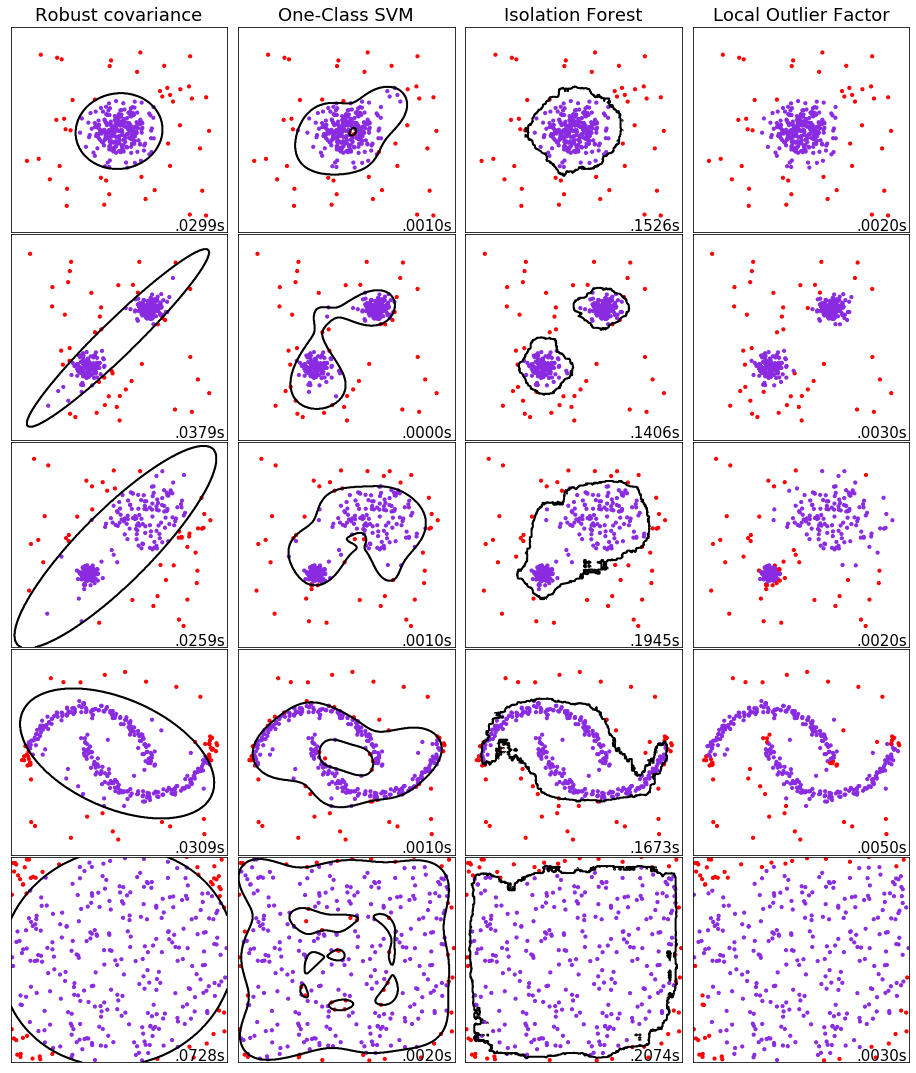

In [8]:
xx, yy = np.meshgrid(np.linspace(-7,7,500), np.linspace(-7,7,500))

plt.figure(figsize = (len(anomaly_algorithms)*2+5, 15))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05, hspace=.01)

plot_num = 1
rng = np.random.RandomState(13192)

for i_dataset, X in enumerate(datasets):
    # first add outliers
    X = np.concatenate([X, rng.uniform(low=-6, high=6, size = (n_outliers, 2))], axis = 0)
    
    for name, algorithm in anomaly_algorithms:
        t0 = time.time()
        algorithm.fit(X)
        t1 = time.time()
        
        plt.subplot(len(datasets), len(anomaly_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)
        
        # fit and predict
        if name == "Local Outlier Factor":
            y_pred = algorithm.fit_predict(X)
        else:
            y_pred = algorithm.fit(X).predict(X)
        
        # plot (Local Outlier Factor does not have a contour)
        if name != "Local Outlier Factor":
            Z = algorithm.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            plt.contour(xx, yy, Z, levels = [0], linewidths = 2, colors = 'black')
            
        colors = np.array(['red','blueviolet'])
        plt.scatter(X[:,0], X[:,1], s=10, color = colors[(y_pred + 1) // 2])
        
        plt.xlim(-7, 7)
        plt.ylim(-7, 7)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.4fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1
        
plt.show()